所需要的软件：
anaconda（python） https://www.anaconda.com/

服务器、数据库、量化策略

# 服务器

数据库的作用可以想象成一台24小时工作的云计算机，主要的作用是可以24小时运行代码，全天候监控量化程序。

**获得方法：**

付费版：阿里云，腾讯云


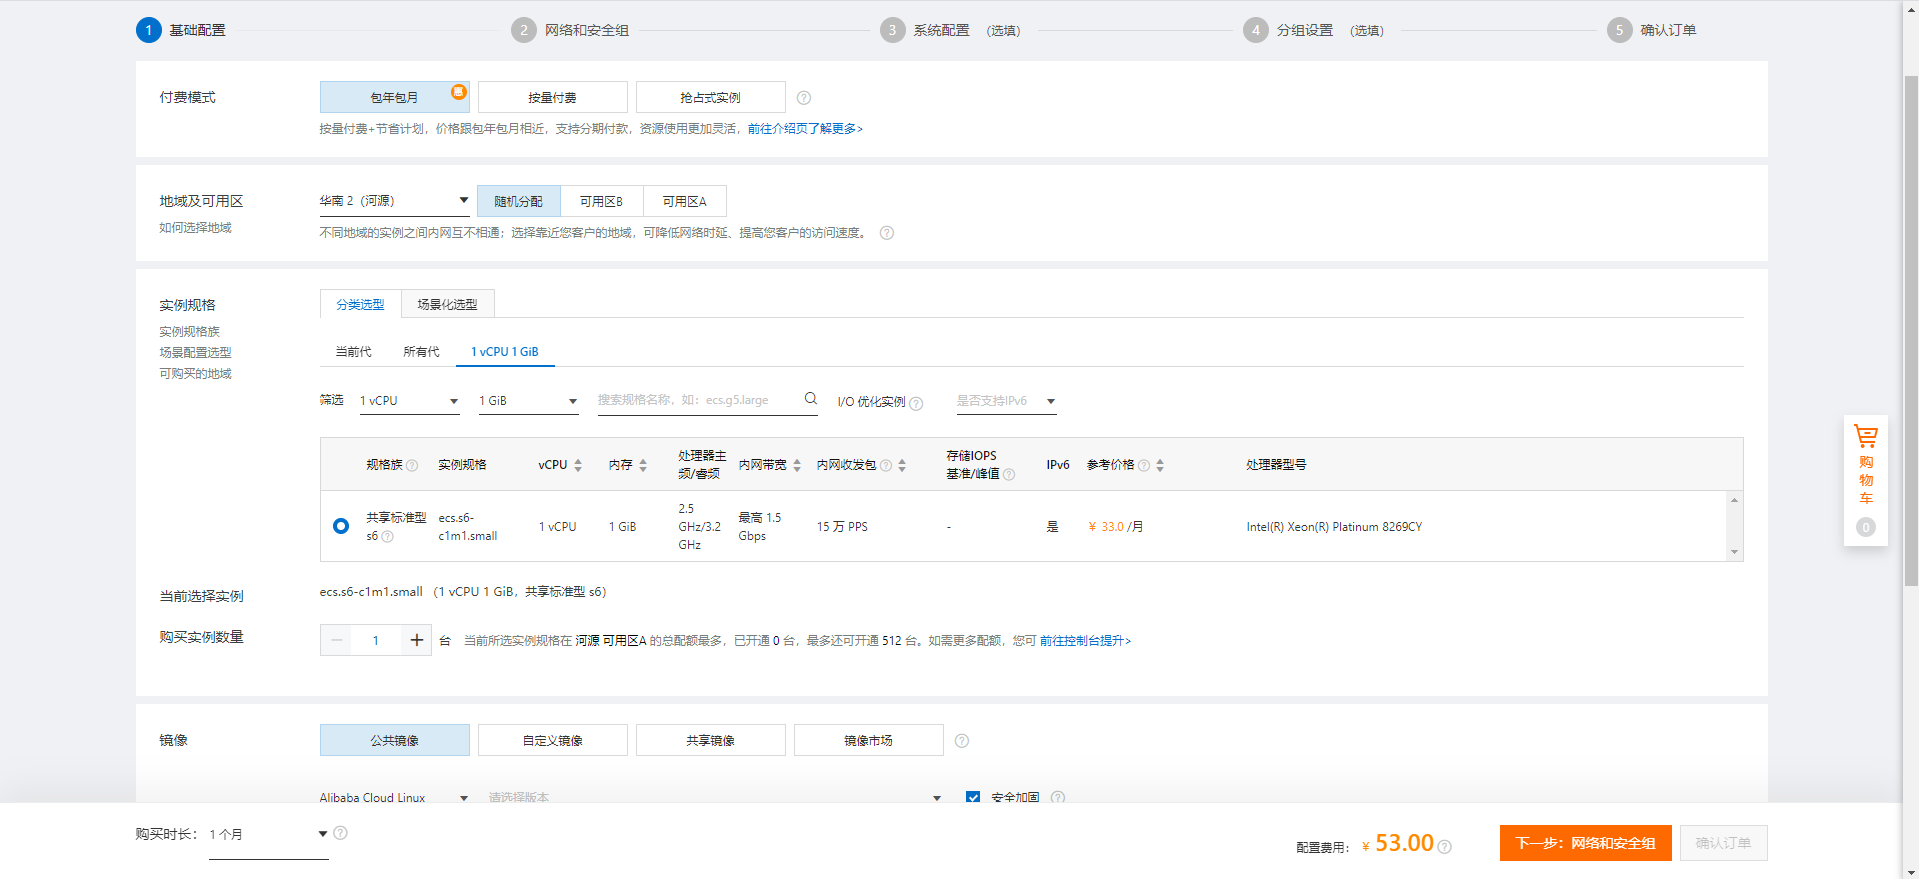

免费版:甲骨文、亚马逊云均有免费版的linux服务器，可以自行上他们官网申请。

# 数据库

当我们需要存储大量的数据的时候，例如，分钟级别的BTC数据，如果存储到个人电脑上需要好几个G,第一是不方便使用，第二是数据量也大，因此我们需要一个数据库来帮我们存储数据，在需要的时候直接调用就好。

__付费版：__

阿里云、腾讯云

__免费版：__

甲骨文、AWS

**数据库可视化软件：**

Navicat

Vscode

# 量化框架

## 导入数据

数据库IP: 

research.jacarandastock.com

端口:

3306

数据库名称：

test

登录名：

research

登录密码：

ouCPoD7Zfkik4C@g7u

In [1]:
# 安装必要的package
# pip install pymysql

In [5]:
import pandas as pd
# import time
# import datetime
from sqlalchemy import create_engine
import pymysql
# from dateutil import parser
# import json
import matplotlib.pyplot as plt
# import seaborn as sns

In [7]:
conn = pymysql.connect(host='jacarandastock.com',port=3306, user='mysql', 
                       passwd='pssYZR^yS332%wB4', db='jacaranda', charset='utf8')

MySQL 语句可以参见 菜鸟教程

https://www.runoob.com/mysql/mysql-tutorial.html

## 获得数据

In [16]:
sql="SELECT * from btc_1day"
# btc_1min
data = pd.read_sql(sql,conn)

为了避免其他情况，数据被提前导出并保存了起来

In [15]:
# data.to_csv('BTC_1day.csv')

# pd.read_csv('BTC_1day.CSV'')

In [13]:
data.head()

,time,open,high,low,close,volume
0,2020-01-01 16:00:00,7231.8,7248.7,7106.1,7131.9,9662.51693926
1,2020-01-02 16:00:00,7131.9,7376.3,6870.7,7319.5,35308.2816697
2,2020-01-03 16:00:00,7320.3,7404.8,7260.0,7318.8,15952.28797901
3,2020-01-04 16:00:00,7318.9,7494.7,7272.5,7467.3,17497.52711724
4,2020-01-05 16:00:00,7467.3,7610.1,7319.0,7521.3,23436.77977471


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    617 non-null    datetime64[ns]
 1   open    617 non-null    object        
 2   high    617 non-null    object        
 3   low     617 non-null    object        
 4   close   617 non-null    object        
 5   volume  617 non-null    object        
dtypes: datetime64[ns](1), object(5)
memory usage: 29.0+ KB


## 数据处理

In [17]:
data['time'] = pd.to_datetime(data['time'])

In [20]:
data.set_index('time', inplace=True)

In [22]:
data= data.astype('float64')

In [23]:
data.head()

,open,high,low,close,volume
time,,,,,
2020-01-01 16:00:00,7231.8,7248.7,7106.1,7131.9,9662.516939
2020-01-02 16:00:00,7131.9,7376.3,6870.7,7319.5,35308.281670
2020-01-03 16:00:00,7320.3,7404.8,7260.0,7318.8,15952.287979
2020-01-04 16:00:00,7318.9,7494.7,7272.5,7467.3,17497.527117
2020-01-05 16:00:00,7467.3,7610.1,7319.0,7521.3,23436.779775


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 617 entries, 2020-01-01 16:00:00 to 2021-09-08 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    617 non-null    float64
 1   high    617 non-null    float64
 2   low     617 non-null    float64
 3   close   617 non-null    float64
 4   volume  617 non-null    float64
dtypes: float64(5)
memory usage: 28.9 KB


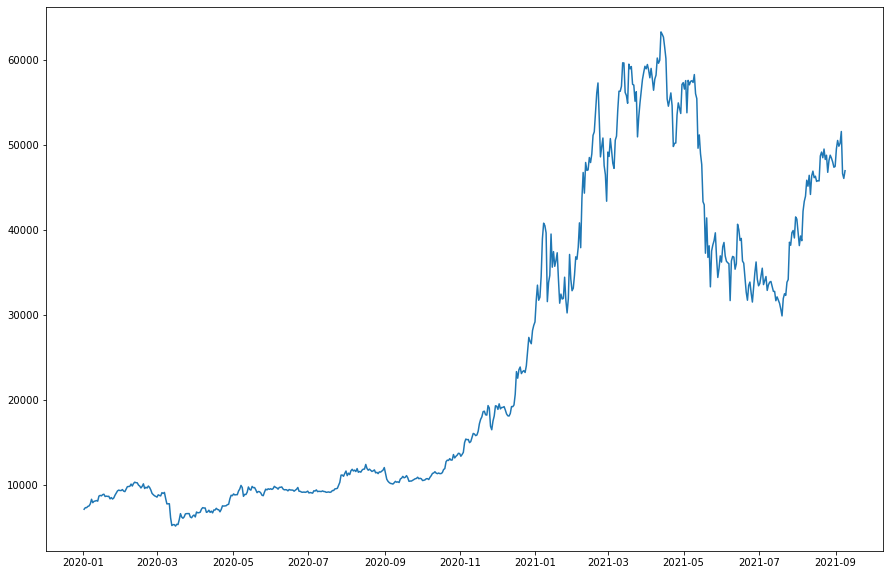

In [25]:
plt.figure(figsize=(15,10))
plt.plot(data['close'])
plt.show()

In [26]:
data.columns = ['Open','High','Low','Close','Volume']

## 编写量化策略

In [27]:
from backtesting import Backtest, Strategy

from backtesting.lib import crossover
from backtesting.test import SMA, GOOG

C:\ProgramData\Anaconda3\lib\site-packages\backtesting\_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [26]:
# pip install backtesting

In [27]:
def expsmooth(data,alpha):
    data = pd.DataFrame(data)
    smoothed = data.ewm(alpha, adjust=False).mean()
    return smoothed

In [28]:
class SmaCross(Strategy):
    n1 = 5 # 5日均线
    n2 = 10 # 10日均线

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()


In [34]:
# 进行回测
bt = Backtest(data, SmaCross,
              cash=100000, commission=.003,
              exclusive_orders=True)

output = bt.run()

bt.plot()

<ipython-input-34-44030c5bbad3>:8: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot()


In [33]:
pd.DataFrame(output)

,0
Start,2020-01-01 16:00:00
End,2021-09-08 16:00:00
Duration,616 days 00:00:00
Exposure Time [%],96.43436
Equity Final [$],124920.0972
Equity Peak [$],229355.1269
Return [%],24.920097
Buy & Hold Return [%],558.85248
Return (Ann.) [%],14.068304
Volatility (Ann.) [%],88.756387


# 实盘交易：

**加密货币：**

Binance、Okex、Huobi 官网均有量化接口，可以进行实时买卖

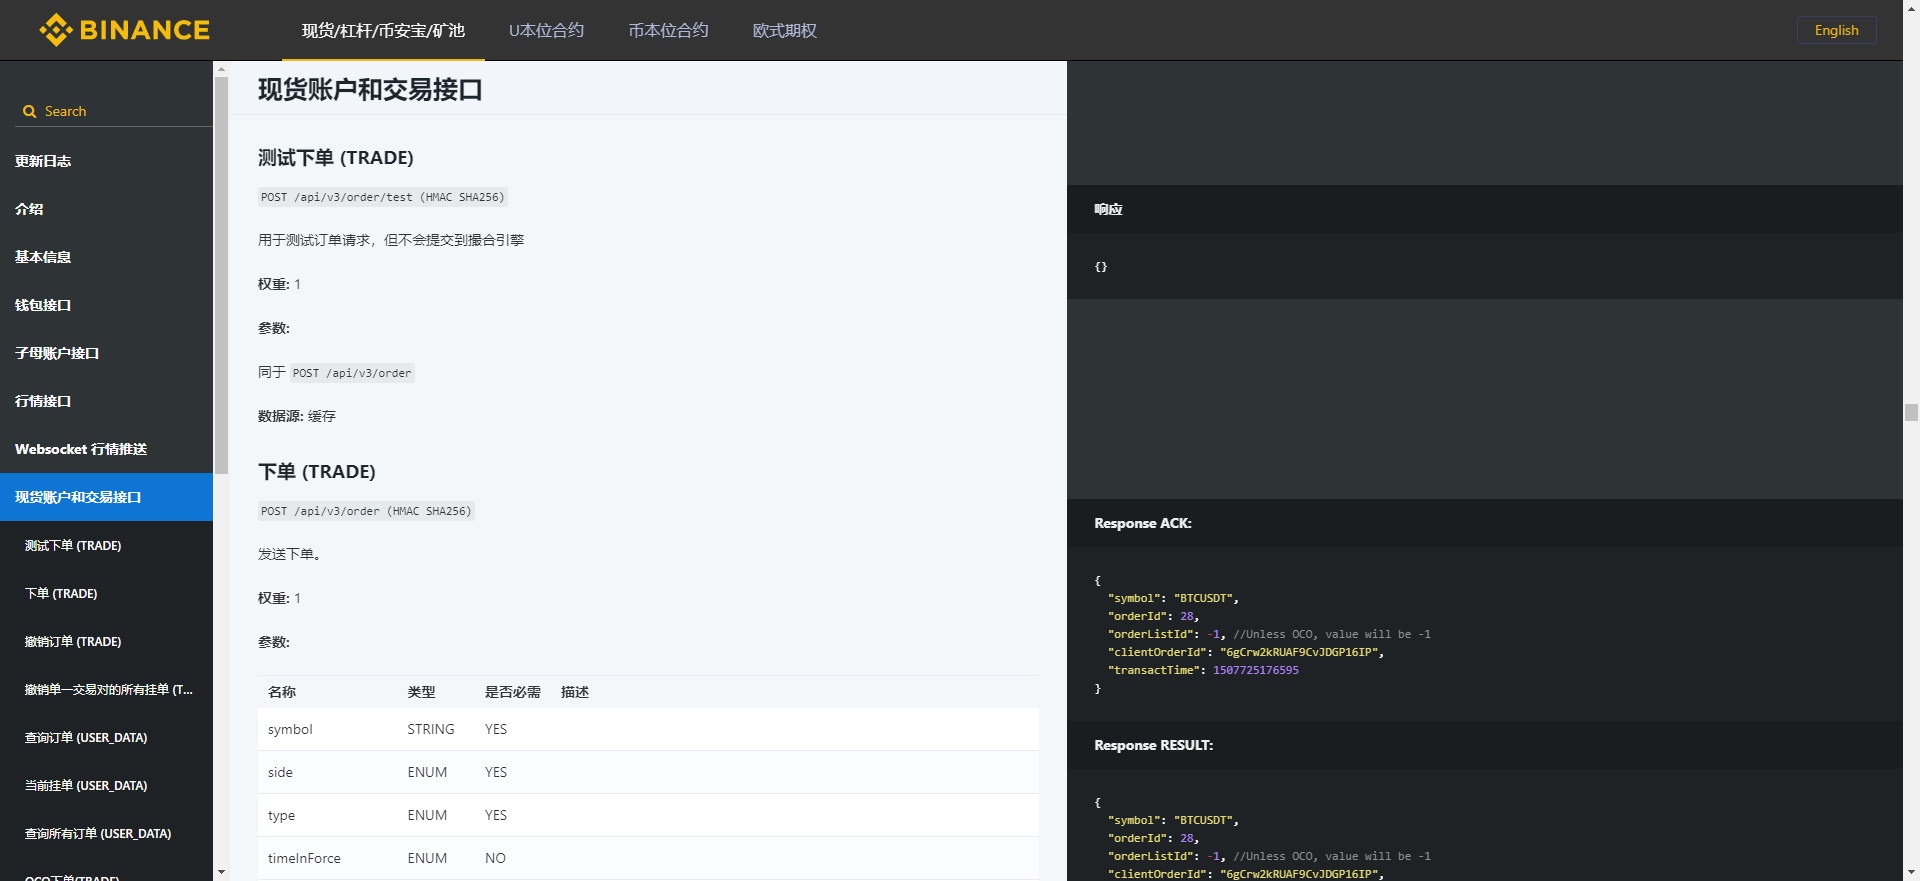

**A股**